In [ ]:
# nltk sentence splitter 사용할지 안할지 몰라서 일단 만들어 놓음
# punkt_param = PunktParameters()
# prefixes = ['Mr', 'Mrs', 'St', 'MS', 'Dr', 'Prof', 'Capt', 'Cpt', 'Lt', 'Mt', 'Jr']
# prefixes_low = [pref.lower() for pref in prefixes]
# punkt_param.abbrev_types = set(prefixes + prefixes_low)
# sentence_splitter = PunktSentenceTokenizer(punkt_param)

In [1]:
# !pip install contractions
# import contractions
import seaborn as sns
import re
import nltk 
import os
from bs4 import BeautifulSoup
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
nltk.download('punkt')

     |████████████████████████████████| 327kB 5.1MB/s 
     |████████████████████████████████| 286kB 9.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85408 sha256=b9a69ff14e477d19ba97a6b24a0286ea23163931eb11d2d75c9409879554cead
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences
# sentence splitter function
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt|Jr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She \s|It \s|They \re|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|me|edu)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [3]:
def html_preprocessing(corpus):
  corpus = BeautifulSoup(corpus, 'lxml').text
  return corpus

def html_re_preprocessing(corpus):
  # html 기호들 전처리 
  corpus = re.sub("&nbsp;", " ", corpus)
  corpus = re.sub("&It;", "<", corpus)
  corpus = re.sub("%amp;", "and", corpus)
  corpus = re.sub("quot;", '"', corpus)
  corpus = re.sub("&#035;", "#", corpus)
  corpus = re.sub("&#039;", "'", corpus)
  return corpus

In [61]:
def preprocessing(corpus, dataset = "coca"):
  corpus = html_preprocessing(corpus)
  if dataset == "coca":
    corpus = corpus[10:]
  # 아래 코드는 html 요소들 지우기 위한 코드 
  corpus = re.sub("&nbsp;", " ", corpus)
  corpus = re.sub("&It;", "<", corpus)
  corpus = re.sub("%amp;", "and", corpus)
  corpus = re.sub("quot;", '"', corpus)
  corpus = re.sub("&#035;", "#", corpus)
  corpus = re.sub("&#039;", "'", corpus)

  # corpus = re.sub("\\'(.)", "'\\1", corpus)
  corpus = re.sub("wo n't", "won't", corpus)
  corpus = re.sub("(\$) ?([0-9])", "dollar \\2", corpus)
  corpus = re.sub("%", 'percent', corpus)
  corpus = re.sub("@!", "", corpus)
  corpus = re.sub("^[0-9a-zA-Z]([-_.]?[0-9a-zA-Z])*@[0-9a-zA-Z]([-_.]?[0-9a-zA-Z])*.[a-zA-Z]{2,3}$/i", "EMAIL", corpus) # 이메일
  corpus = re.sub('http : //\S+|https : //\S+', '', corpus, flags=re.MULTILINE) # not complete
  corpus = re.sub("[\(\[] ?.*? ?[\)\]]", '', corpus) 
  corpus = re.sub("[0-9]", " NUM ", corpus) 

  corpus = re.sub('\.', 'thisIsSpecialTokenForProd', corpus)
  corpus = re.sub(" ", "thisIsSpecialTokenForBlank", corpus)
  corpus = re.sub("(\W){2,}", "\\1", corpus)
  corpus = re.sub("thisIsSpecialTokenForProd", ".", corpus)
  corpus = re.sub("thisIsSpecialTokenForBlank", " ", corpus)
  
  corpus = re.sub("\.{2,}", ".", corpus)
  corpus = split_into_sentences(corpus)
  corpus = [sentence for sentence in corpus if (len(sentence.split(" ")) > 3) and ("@ @ @ @ @ @ @ @ @ @" not in sentence)]
  return corpus

In [17]:
# EDA 함수들
def count_words(corpus, counter = Counter(), tokenizer = get_tokenizer('spacy')):
  for sent in corpus:
    counter.update(tokenizer(sent))
  return counter
def tokenizing(corpus, vocab, tokenizer):
  result = []
  for sent in corpus:
    sent_tokens = [vocab[token] for token in tokenizer(sent)]
    result.append(sent_tokens)
  return result
def sumUptheWordsCount(corpus):
  sum_ = 0
  for sent in corpus:
    sum_ += len(sent) 
  return sum_

In [18]:
def EDA(corpus, tokenizer = get_tokenizer('spacy')):
  # EDA 코드 
  file_preprocessed = [preprocessing(sentence) for sentence in corpus]
  corpus_list = sum(file_preprocessed, [])
  print(f"전체 문장 수 : {len(corpus_list)}")

  corpus_counter = count_words(corpus_list, tokenizer = tokenizer)
  corpus_vocab = Vocab(corpus_counter)
  print(f"전체 단어 수 : {len(corpus_vocab.vocab)}")

  tokenized_corpus = tokenizing(corpus_list, corpus_vocab, tokenizer)
  sentence_len = [len(sent) for sent in tokenized_corpus]
  summed = sumUptheWordsCount(tokenized_corpus)
  print(f"문장 평균 단어 수 : {summed/len(corpus_list):.3f}")
  print(f"문장 최대 최소 단어 수 : {max(sentence_len), min(sentence_len)}")
  sns.distplot(sentence_len)

In [7]:
raw_path = "/content/drive/Shareddrives/text_conf/dataset/raw/"
coca_path = "COCA/coca-samples-text/"
gyafc_path = "GYAFC/GYAFC_Corpus"
save_path = "/content/drive/Shareddrives/text_conf/dataset/preprocessed/"
coca_save_path = "native/"

In [8]:
coca_files = [file for file in os.listdir(raw_path + coca_path) if "0_" in file]

--------------------------------------------------
0_text_acad.txt
--------------------------------------------------
전체 문장 수 : 44512
전체 단어 수 : 146689
문장 평균 단어 수 : 23.741
문장 최대 최소 단어 수 : (215, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
0_text_blog.txt
--------------------------------------------------
전체 문장 수 : 57545
전체 단어 수 : 146689
문장 평균 단어 수 : 19.739
문장 최대 최소 단어 수 : (205, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
0_text_mag.txt
--------------------------------------------------
전체 문장 수 : 55621
전체 단어 수 : 146689
문장 평균 단어 수 : 21.616
문장 최대 최소 단어 수 : (194, 4)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
0_text_news.txt
--------------------------------------------------
전체 문장 수 : 53077
전체 단어 수 : 146689
문장 평균 단어 수 : 20.717
문장 최대 최소 단어 수 : (336, 4)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
0_text_web.txt
--------------------------------------------------
전체 문장 수 : 50862
전체 단어 수 : 146689
문장 평균 단어 수 : 20.396
문장 최대 최소 단어 수 : (239, 4)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None


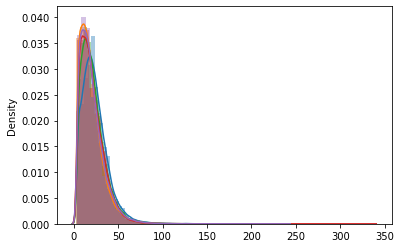

In [63]:
result = []
for coca in coca_files:
  with open(raw_path+coca_path+coca, encoding = 'UTF-8', newline = '\n') as f:
    corpus = f.readlines()[1:]
    preprocessed = sum([preprocessing(sent) for sent in corpus], [])
    result.extend(preprocessed)
    print("-"*50)
    print(coca)
    print("-"*50)
    print(EDA(preprocessed))
with open(save_path+coca_save_path+"COCA_preprocessed_merged", encoding = "UTF-8", newline = "\n", mode = "w") as g:
  g.writelines(result)

In [49]:
raw_path = "/content/drive/Shareddrives/text_conf/dataset/raw/"
coca_path = "COCA/coca-samples-text/"
gyafc_path = "GYAFC/GYAFC_Corpus/"
save_path = "/content/drive/Shareddrives/text_conf/dataset/preprocessed/"
coca_save_path = "native/"

gern_list = ["Entertainment_Music", "Family_Relationships"]
set_list = ["train", "tune", "test"]
label_list = ["formal", "informal"]

--------------------------------------------------
Entertainment_Musictrainformal
--------------------------------------------------
전체 문장 수 : 42857
전체 단어 수 : 146689
문장 평균 단어 수 : 10.468
문장 최대 최소 단어 수 : (78, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
Family_Relationshipstrainformal
--------------------------------------------------
전체 문장 수 : 43479
전체 단어 수 : 146689
문장 평균 단어 수 : 10.882
문장 최대 최소 단어 수 : (44, 4)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
Entertainment_Musictuneformal
--------------------------------------------------
전체 문장 수 : 1953
전체 단어 수 : 146689
문장 평균 단어 수 : 10.632
문장 최대 최소 단어 수 : (38, 5)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Family_Relationshipstuneformal
--------------------------------------------------
전체 문장 수 : 1841
전체 단어 수 : 146689
문장 평균 단어 수 : 10.222
문장 최대 최소 단어 수 : (31, 5)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Entertainment_Musictestformal
--------------------------------------------------
전체 문장 수 : 876
전체 단어 수 : 146689
문장 평균 단어 수 : 10.748
문장 최대 최소 단어 수 : (44, 5)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Family_Relationshipstestformal
--------------------------------------------------
전체 문장 수 : 855
전체 단어 수 : 146689
문장 평균 단어 수 : 10.498
문장 최대 최소 단어 수 : (39, 4)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Entertainment_Musictraininformal
--------------------------------------------------
전체 문장 수 : 23304
전체 단어 수 : 146689
문장 평균 단어 수 : 9.490
문장 최대 최소 단어 수 : (68, 3)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Family_Relationshipstraininformal
--------------------------------------------------
전체 문장 수 : 31156
전체 단어 수 : 146689
문장 평균 단어 수 : 10.112
문장 최대 최소 단어 수 : (38, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


None
--------------------------------------------------
Entertainment_Musictuneinformal
--------------------------------------------------
전체 문장 수 : 1315
전체 단어 수 : 146689
문장 평균 단어 수 : 9.376
문장 최대 최소 단어 수 : (27, 4)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Family_Relationshipstuneinformal
--------------------------------------------------
전체 문장 수 : 1585
전체 단어 수 : 146689
문장 평균 단어 수 : 9.879
문장 최대 최소 단어 수 : (24, 4)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Entertainment_Musictestinformal
--------------------------------------------------
전체 문장 수 : 660
전체 단어 수 : 146689
문장 평균 단어 수 : 9.826
문장 최대 최소 단어 수 : (28, 4)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------------------------------------------
Family_Relationshipstestinformal
--------------------------------------------------
전체 문장 수 : 777
전체 단어 수 : 146689
문장 평균 단어 수 : 10.122
문장 최대 최소 단어 수 : (28, 4)
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


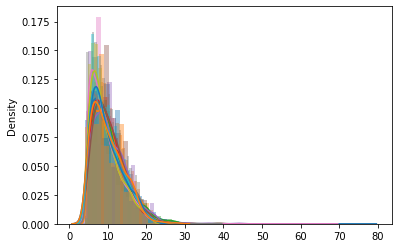

In [64]:
for label in label_list:
  for set_ in set_list:
    result = []
    for gern in gern_list:
      with open(f"{raw_path}{gyafc_path}{gern}/{set_}/{label}", encoding = 'UTF-8', newline = '\n') as f:
        corpus = f.readlines()
        preprocessed = sum([preprocessing(sent, dataset = None) for sent in corpus], [])
        result.extend(preprocessed)
        print("-"*50)
        print(gern + set_ + label)
        print("-"*50)
        print(EDA(preprocessed))
      with open(f"{save_path}{label}/{gern}_{set_}", encoding = "UTF-8", newline = "\n", mode = "w") as g:
        g.writelines(preprocessed)
    with open(f"{save_path}{label}/{set_}_merged", encoding = "UTF-8", newline = "\n", mode = "w") as g:
        g.writelines(result)  

In [65]:
for coca in coca_files:
  with open(raw_path+coca_path+coca, encoding = 'UTF-8', newline = '\n') as f:
    corpus = f.readlines()[1:]
    preprocessed = [preprocessing(sent) for sent in corpus]
    print("-"*50)
    print("-"*50)
    print("-"*50)
    print(coca)
    print("-"*50)
    print("-"*50)
    print("-"*50)
    print("-"*50)
    print(*sum(preprocessed, [])[:1000], sep = "\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
I have come close to implying that the Ninth Edition of the Encyclopaedia Britannica was a kind of father figure to me .
At that time , all these sentiments were also true of my unquestioned attitudes toward my father .
Writing my own article for the EB was a psychological landmark ; it gave me a voice of my own .
I suddenly felt like Ernest Pontifex , in The Way of All Flesh , who was finally able to contravene his father without feeling that he was either destroying or betraying him .
Before I wrote my  NUM  NUM  NUM  NUM  article , I looked at two or three earlier pieces .
It did not occur to me then to view them as documents of intellectual history ; I merely wished to identify my predecessors ' pitfalls - such as an overreliance on dreary tables of statistics - so I could avoid stepping into them myself .
I wrote the article and proudly added the Fourteenth Edition of the Britannica to the Ninth Edition that still reposed in the glass-fronted St

In [58]:
for label in label_list:
  for set_ in set_list:
    for gern in gern_list:
      with open(f"{raw_path}{gyafc_path}{gern}/{set_}/{label}", encoding = 'UTF-8', newline = '\n') as f:
        corpus = f.readlines()
        preprocessed = sum([preprocessing(sent, dataset = None) for sent in corpus], [])
        print("-"*50)
        print("-"*50)
        print("-"*50)
        print(f"{gern}_{set_}_{label}")
        print("-"*50)
        print("-"*50)
        print("-"*50)
        print("-"*50)
        print(*preprocessed[:1000], sep = "\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
don't remember her name Dr. troy and kimber's ex girlfriend.
it's the only thing that sounds real.
I tried it but not hard enough.
the # NUM  fret is the very top one.
i think it was that lady detective .
don't remember her name Dr. troy and kimber's ex girlfriend.
it's the only thing that sounds real.
I tried it but not hard enough.
you can not find the notes length.
Maybe if he did something normal, now that would be shocking LOL.
i donno but i think linkin is for linking.
) J/k I'd ask it again and don't let it get this old.
don't download films you haven't bought.
Try to download Limewire from www.
Yes I have seen the movie.
band tho)  and sink into the underground.
Because they are have Intel inside.
Yes I have seen the movie.
band tho)  and sink into the underground.
Because they are have Intel inside.
Kiss a stranger, say hi to someone you usually wouldn't.
AND WHILE SHE LOOKED SO SAD IN PHOTOGRAPHS,  I ABSOLUTELY LOVE HER,  WHEN SHE SMILES.
I